# Model training

This notebook is used to train and compare a set of models on the data splits. This step is done to identify the best performing model.

In [8]:
import pandas as pd
from tqdm import tqdm
from pycaret.classification import *

import seaborn as sns
import matplotlib.pyplot as plt

# Model Training and comparison 

In [9]:
def train_model_pipeline(
    data: pd.DataFrame, test_data: pd.DataFrame, metric: str, exp_name: str
):
    """PyCaret pipeline for training a model on a dataset, selecting the bet and saving it to disk."""

    setup(
        data=data,
        target="label",
        test_data=test_data,
        index=False,
        train_size=0.8,  # train-validation split
        low_variance_threshold=0,
        fold_strategy="stratifiedkfold",  # CV strategy
        fold=5,  # CV strategy
        experiment_name=exp_name,
        verbose=False,
    )

    compare_models(
        sort=metric,
        round=2,  # number of decimal places for metric
        include=["nb", "lr", "lightgbm", "dt", "rf", "xgboost"],
        fold=5,
        verbose=False,
    )  # Gets the best model based on the metric for hold-out set

    eval_results = pull()
    return eval_results

In [10]:
eval_results = {}

for fingerprint_name in tqdm(["ecfp4", "rdkit", "maccs", "mhfp6", "erg", "chemphys"]):
    train_data = pd.read_csv(f"../data/splits/{fingerprint_name}_train.csv")
    train_with_smote = pd.read_csv(f"../data/splits/{fingerprint_name}_smote_train.csv")
    test_data = pd.read_csv(f"../data/splits/{fingerprint_name}_test.csv")

    results = train_model_pipeline(
        data=train_data,
        test_data=test_data,
        metric="Kappa",
        exp_name=f"{fingerprint_name}",
    )

    eval_results[f"{fingerprint_name}"] = results

    smote_results = train_model_pipeline(
        data=train_with_smote,
        test_data=test_data,
        metric="Kappa",
        exp_name=f"{fingerprint_name}_with_smote",
    )

    eval_results[f"{fingerprint_name}_smote"] = smote_results

100%|██████████| 6/6 [1:51:45<00:00, 1117.60s/it]  


# Hold-off set performance evaluation

In [11]:
final_eval_df = []

for fingerprint_name, results in eval_results.items():
    for (
        model_name,
        acc,
        auc,
        recall,
        precision,
        f1,
        kappa,
        mcc,
        time,
    ) in results.values:
        final_eval_df.append(
            {
                "fingerprint": fingerprint_name
                if "smote" not in fingerprint_name
                else fingerprint_name.split("_")[0],
                "Train type": "SMOTE" if "smote" in fingerprint_name else "Orginal",
                "Model": model_name,
                "kappa": kappa,
            }
        )

final_eval_df = pd.DataFrame(final_eval_df)
final_eval_df["fingerprint"] = final_eval_df["fingerprint"].map(
    {
        "ecfp4": "ECFP4",
        "rdkit": "RDKit",
        "maccs": "MACCS",
        "mhfp6": "MHFP6",
        "erg": "ErG",
        "chemphys": "ChemPhys",
    }
)

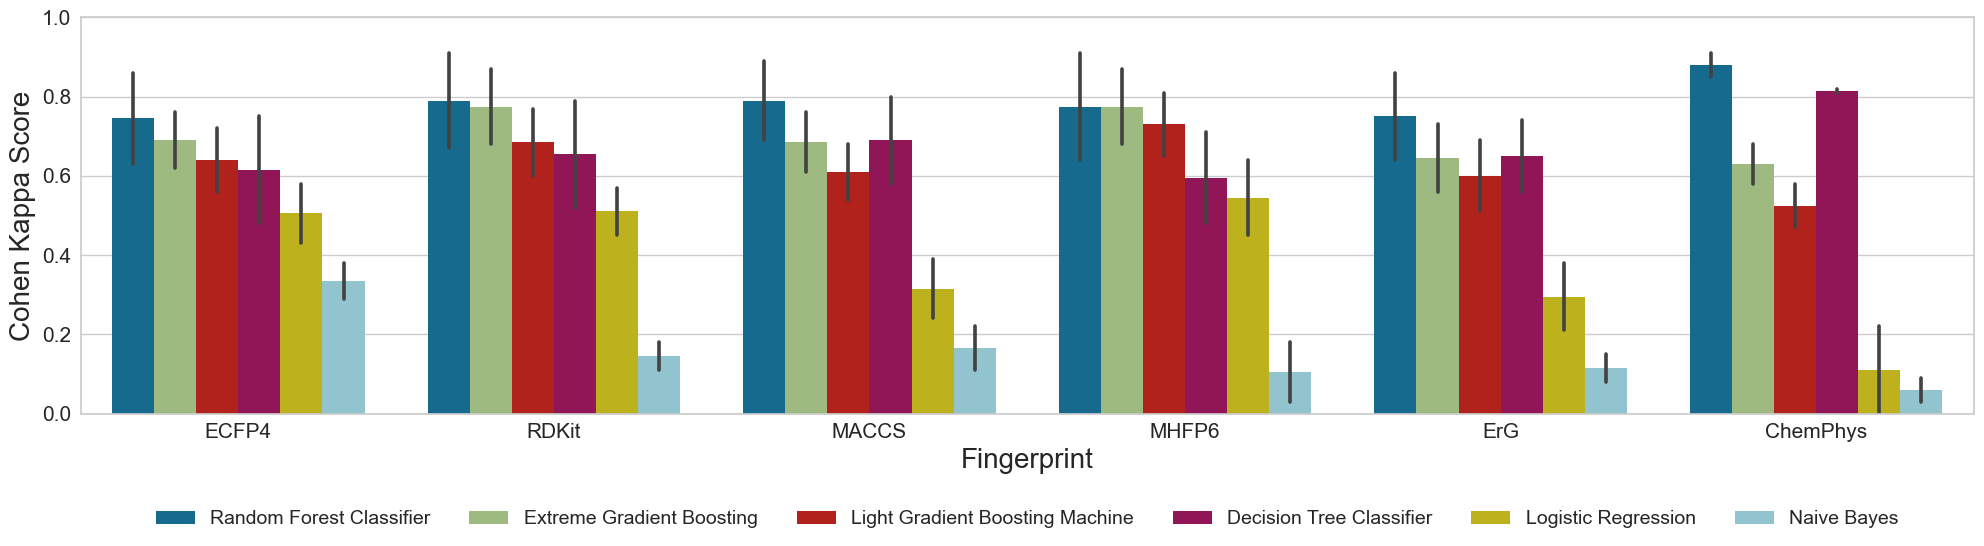

In [12]:
plt.figure(figsize=(20, 5))
sns.barplot(
    data=final_eval_df,
    x="fingerprint",
    y="kappa",
    hue="Model",
    # hue_order=["Orginal", "SMOTE"],
)
plt.ylabel("Cohen Kappa Score", fontsize=20)
plt.xlabel("Fingerprint", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(0, 1)
plt.tight_layout()

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    shadow=True,
    ncol=6,
    fontsize=14,
)

plt.savefig("../figures/figure_4.png", dpi=400)
plt.show()

### SMOTE against no SMOTE comparison

In [13]:
m = final_eval_df["Model"].isin(
    ["Random Forest Classifier", "Extreme Gradient Boosting"]
)
top_models = final_eval_df[m]

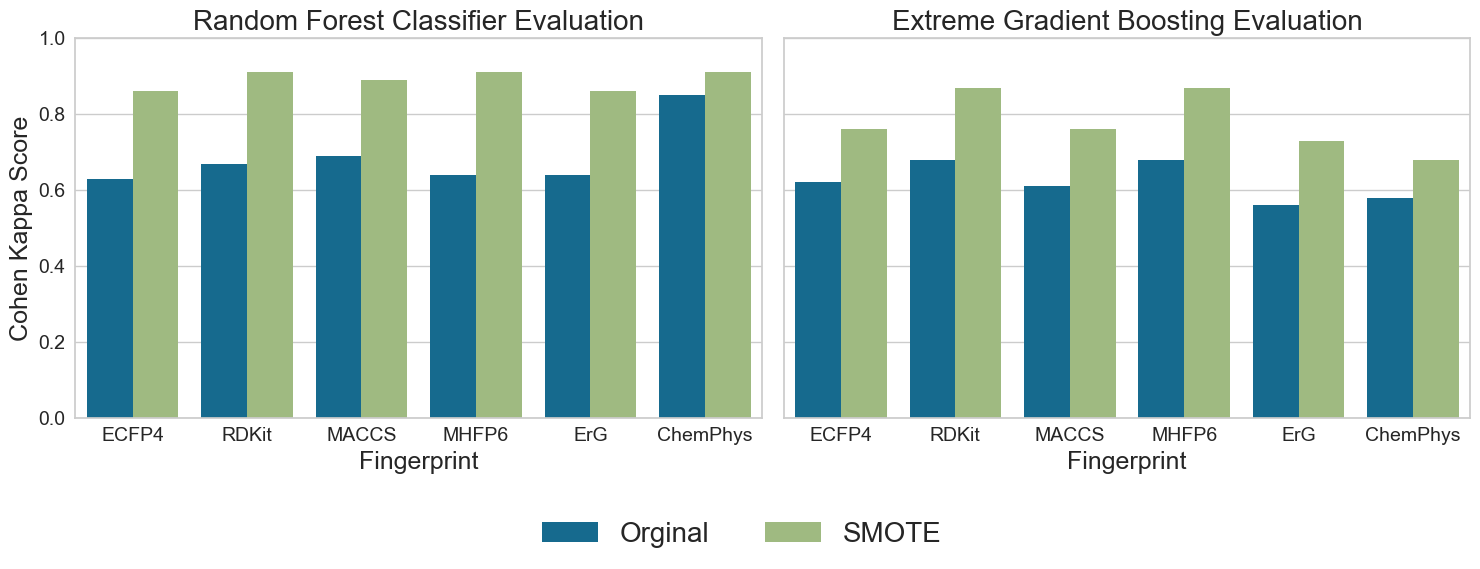

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(
    data=top_models[top_models["Model"] == "Random Forest Classifier"],
    x="fingerprint",
    y="kappa",
    hue="Train type",
    hue_order=["Orginal", "SMOTE"],
    ax=ax1,
)
ax1.set_ylabel("Cohen Kappa Score", fontsize=18)
ax1.set_xlabel("Fingerprint", fontsize=18)
# increase font size of x ticks
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax1.set_ylim(0, 1)

# remove legend
ax1.get_legend().remove()

ax1.set_title("Random Forest Classifier Evaluation", fontsize=20)

sns.barplot(
    data=top_models[top_models["Model"] == "Extreme Gradient Boosting"],
    x="fingerprint",
    y="kappa",
    hue="Train type",
    hue_order=["Orginal", "SMOTE"],
    ax=ax2,
)
ax2.set_ylabel("")
ax2.set_xlabel("Fingerprint", fontsize=18)

# remove y tick labels
ax2.set_yticklabels([])

# increase font size of x ticks
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

ax2.set_ylim(0, 1)
ax2.set_title("Extreme Gradient Boosting Evaluation", fontsize=20)

# remove legend
ax2.get_legend().remove()

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.01),
    ncol=2,
    fontsize=20,
)

plt.tight_layout()
plt.savefig("../figures/figure_5.png", dpi=400)
plt.show()